In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib

In [2]:
%%time

version='v_6_2019-04-23v9'
workdir=os.getcwd()+'/'+version
os.chdir(workdir)
os.makedirs('Transverse/fig', exist_ok=True)
fig_dir=workdir+'/Transverse/fig'
algo_name_old=['F8T2D3D', 'F8Sth0', 'F8Sth10', 'F8Sth20', 'F8Sdr25', 'F8Sdr50', 'F8Sdr100', 'F8Tth0', 'F8Tth10', 'F8Tth20', 'F8Tdr25', 'F8Tdr50', 'F8Tdr100']
algo_name=['T2D3D', 'STCth0', 'STCth10', 'STCth20', 'STCdr25', 'STCdr50', 'STCdr100', 'Tth0', 'Tth10', 'Tth20', 'Tdr25', 'Tdr50', 'Tdr100']
algo={}
for i in range(len(algo_name)):
    algo[i]=pd.read_csv(workdir+'/data/{}.csv'.format(algo_name_old[i]))

CPU times: user 5.73 s, sys: 500 ms, total: 6.23 s
Wall time: 6.54 s


In [3]:
%%time
#cut
ptcut=10
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]
    algo_cut[i].dropna(inplace=True)
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

CPU times: user 1.43 s, sys: 248 ms, total: 1.68 s
Wall time: 1.68 s


In [4]:
from sklearn.model_selection import train_test_split
columns=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean','genpart_pt']


X_train={}
X_test={}
y_train={}
y_test={}

for i in algo:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(algo_cut[i][columns], algo_cut[i]['genpart_pid'], test_size=0.2)

In [5]:
X_pt={}
for i in algo:
    X_pt[i]=X_test[i]['genpart_pt']
    X_test[i]=X_test[i].drop(columns='genpart_pt')
    X_train[i]=X_train[i].drop(columns='genpart_pt')
    
columns.remove('genpart_pt')


In [7]:
train={}
test={}
features=['cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']
for i in algo:
    train[i] = xgb.DMatrix(data=X_train[i][features],label=y_train[i], feature_names=features)
    test[i] = xgb.DMatrix(data=X_test[i][features],label=y_test[i],feature_names=features)

In [8]:
%%time
for i in algo:        
    algo_cut[i]['algo']=algo_name[i]
    algo_cut[i]['electron']=(algo_cut[i]['genpart_pid']==0)
    if i==0:
        algo_all=algo_cut[i]
    else:
        algo_all=pd.concat([algo_all,algo_cut[i]])


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


CPU times: user 2.56 s, sys: 3.88 s, total: 6.44 s
Wall time: 6.45 s


In [9]:
param = {}

# Booster parameters
param['nthread']          = 30  # limit number of threads
param['eta']              = 0.2 # learning rate
param['max_depth']        = 4  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['silent'] = True

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 81  # number of trees to make

In [10]:
%%time
booster={}
for i in algo:
    booster[i] = xgb.train(param,train[i],num_boost_round=num_trees);

CPU times: user 5min 12s, sys: 265 ms, total: 5min 12s
Wall time: 10.4 s


In [11]:
predictions={}
for i in algo:
    print(algo_name[i],'\t',booster[i].eval(test[i]))
    predictions[i]=booster[i].predict(test[i])

T2D3D 	 [0]	eval-error:0.172107	eval-logloss:0.394931	eval-rmse:0.353473
STCth0 	 [0]	eval-error:0.164961	eval-logloss:0.367082	eval-rmse:0.341019
STCth10 	 [0]	eval-error:0.169743	eval-logloss:0.376150	eval-rmse:0.345477
STCth20 	 [0]	eval-error:0.187570	eval-logloss:0.403576	eval-rmse:0.360445
STCdr25 	 [0]	eval-error:0.186209	eval-logloss:0.404149	eval-rmse:0.359984
STCdr50 	 [0]	eval-error:0.196147	eval-logloss:0.424438	eval-rmse:0.369893
STCdr100 	 [0]	eval-error:0.214162	eval-logloss:0.447999	eval-rmse:0.381592
Tth0 	 [0]	eval-error:0.187929	eval-logloss:0.403716	eval-rmse:0.360851
Tth10 	 [0]	eval-error:0.187752	eval-logloss:0.400113	eval-rmse:0.359121
Tth20 	 [0]	eval-error:0.210625	eval-logloss:0.425843	eval-rmse:0.373151
Tdr25 	 [0]	eval-error:0.200751	eval-logloss:0.424248	eval-rmse:0.371011
Tdr50 	 [0]	eval-error:0.202733	eval-logloss:0.424403	eval-rmse:0.371389
Tdr100 	 [0]	eval-error:0.219722	eval-logloss:0.448122	eval-rmse:0.383732


### Evaluate BDT fluctuation by training  times for one algo and plotting AUC

### training on different data set


In [12]:
"""%%time
booster_test={}
pred_test={}
n_train=20
j=1 #training on algo 1: STCth0
plt.figure(figsize=(10,4))
X_train_test={}
X_test_test={}
y_train_test={}
y_test_test={}
test_test={}
train_test={}
auc_score=[]
depth=[4,6,8,10]
for step in depth:
    param[2]=('max_depth',step)
    for i in range(n_train):
        
        X_train_test[i], X_test_test[i], y_train_test[i], y_test_test[i] = train_test_split(algo_cut[j][columns], algo_cut[j]['genpart_pid'], test_size=0.25)
        train_test[i] = xgb.DMatrix(data=X_train_test[i],label=y_train_test[i], feature_names=columns)
        test_test[i] = xgb.DMatrix(data=X_test_test[i],label=y_test_test[i],feature_names=columns)
        booster_test[i]=xgb.train(param,train_test[i],num_boost_round=num_trees)
        pred_test[i]=booster_test[i].predict(test_test[i])
        fpr, tpr, threshold = metrics.roc_curve(y_test_test[i],pred_test[i])
        roc_auc = metrics.auc(fpr, tpr)
        #plt.scatter(i, roc_auc, c='blue')
        auc_score.append(roc_auc)
    print('for num_trees={}, AUC mean={:.4%}, std={:.5%}'.format(num_trees,np.mean(auc_score), np.std(auc_score)))"""

"%%time\nbooster_test={}\npred_test={}\nn_train=20\nj=1 #training on algo 1: STCth0\nplt.figure(figsize=(10,4))\nX_train_test={}\nX_test_test={}\ny_train_test={}\ny_test_test={}\ntest_test={}\ntrain_test={}\nauc_score=[]\ndepth=[4,6,8,10]\nfor step in depth:\n    param[2]=('max_depth',step)\n    for i in range(n_train):\n        \n        X_train_test[i], X_test_test[i], y_train_test[i], y_test_test[i] = train_test_split(algo_cut[j][columns], algo_cut[j]['genpart_pid'], test_size=0.25)\n        train_test[i] = xgb.DMatrix(data=X_train_test[i],label=y_train_test[i], feature_names=columns)\n        test_test[i] = xgb.DMatrix(data=X_test_test[i],label=y_test_test[i],feature_names=columns)\n        booster_test[i]=xgb.train(param,train_test[i],num_boost_round=num_trees)\n        pred_test[i]=booster_test[i].predict(test_test[i])\n        fpr, tpr, threshold = metrics.roc_curve(y_test_test[i],pred_test[i])\n        roc_auc = metrics.auc(fpr, tpr)\n        #plt.scatter(i, roc_auc, c='blue')\

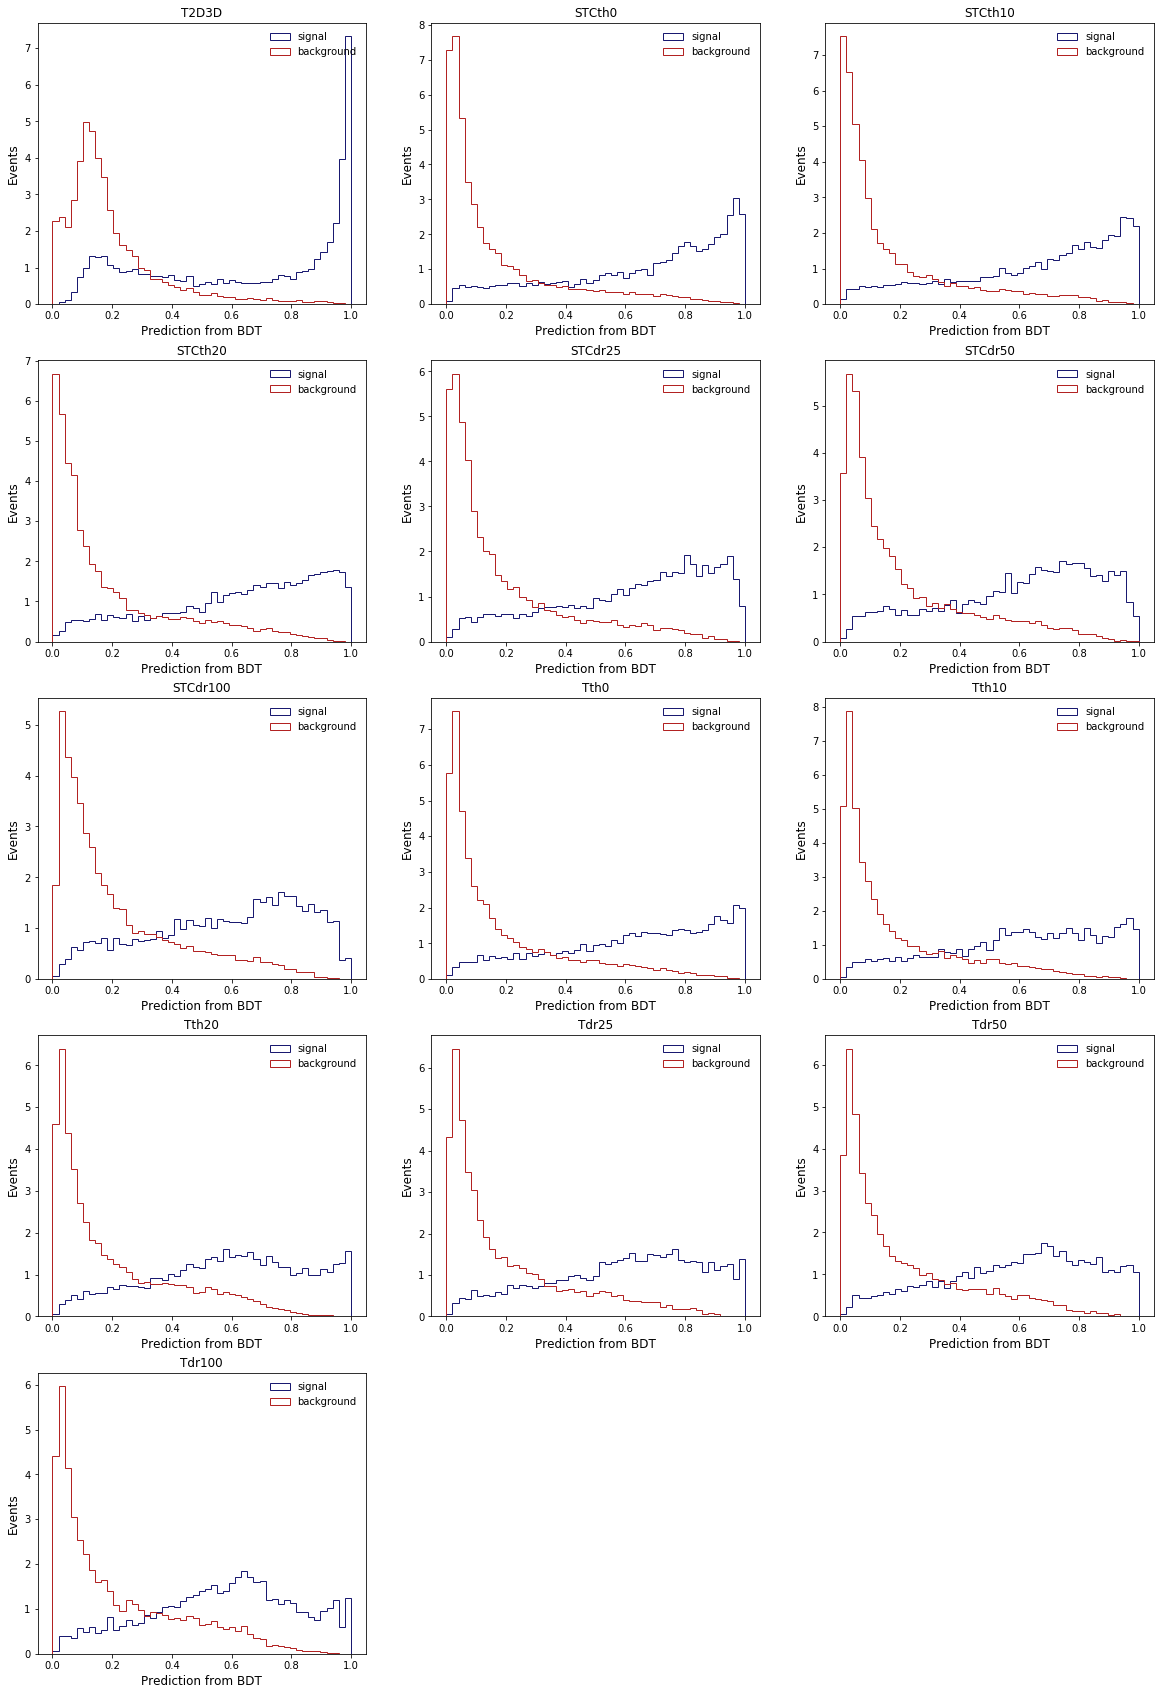

In [13]:
plt.figure(figsize=(20,30));
for i in algo:
# plot all predictions (both signal and background)
    
    plt.subplot(5,3,i+1)
# plot signal and background separately
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal', density=True);
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background', density=True);
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);
plt.savefig(fig_dir+'/predictions.png')

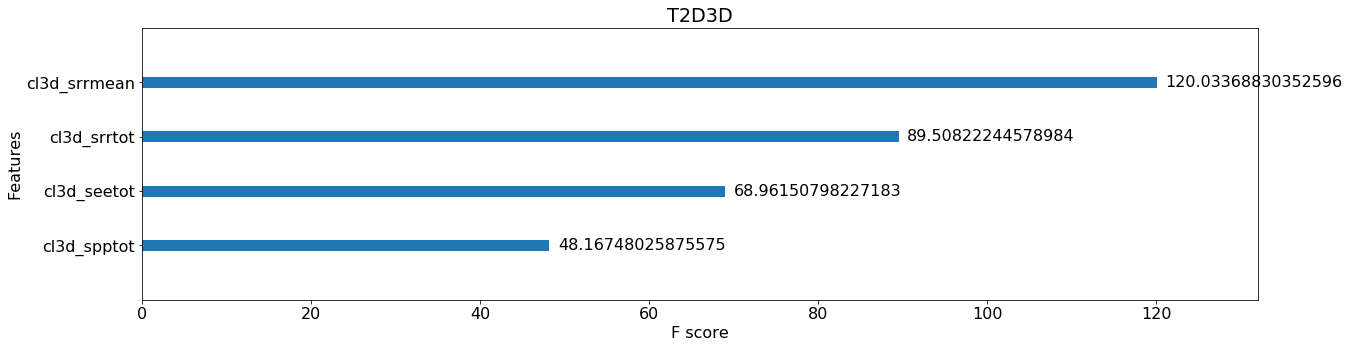

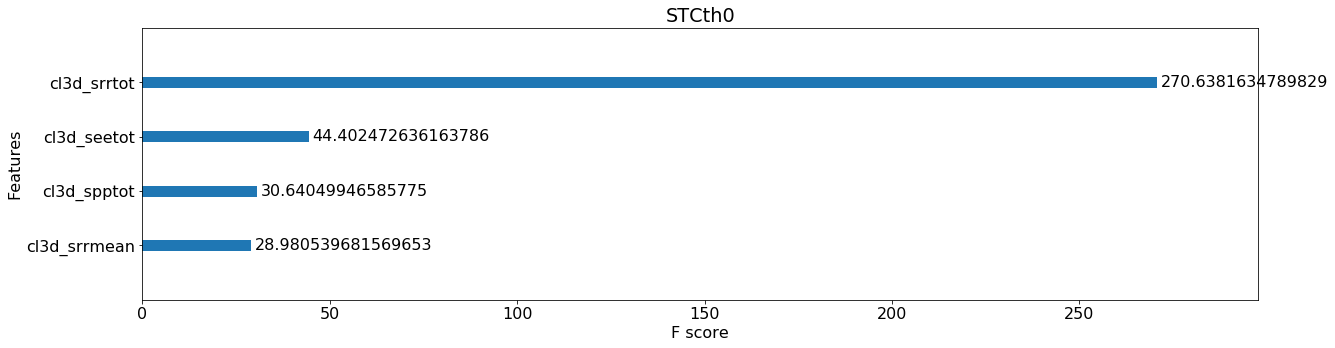

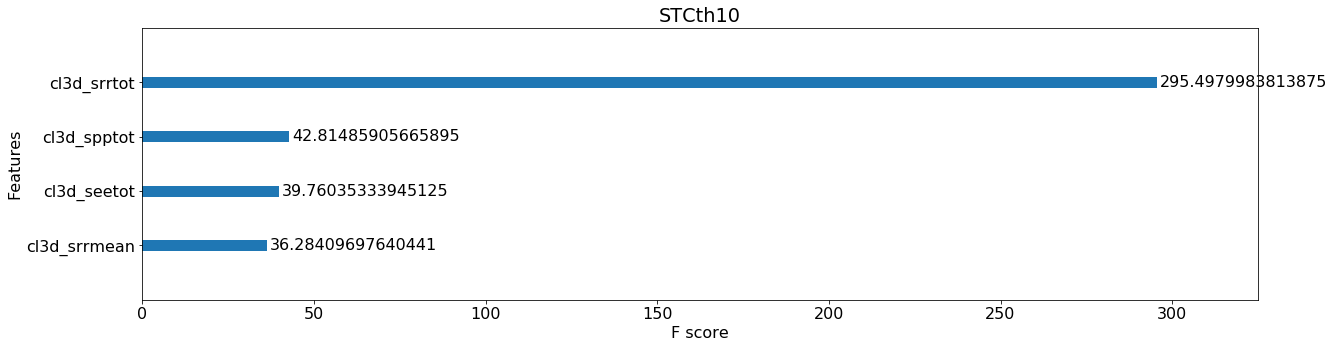

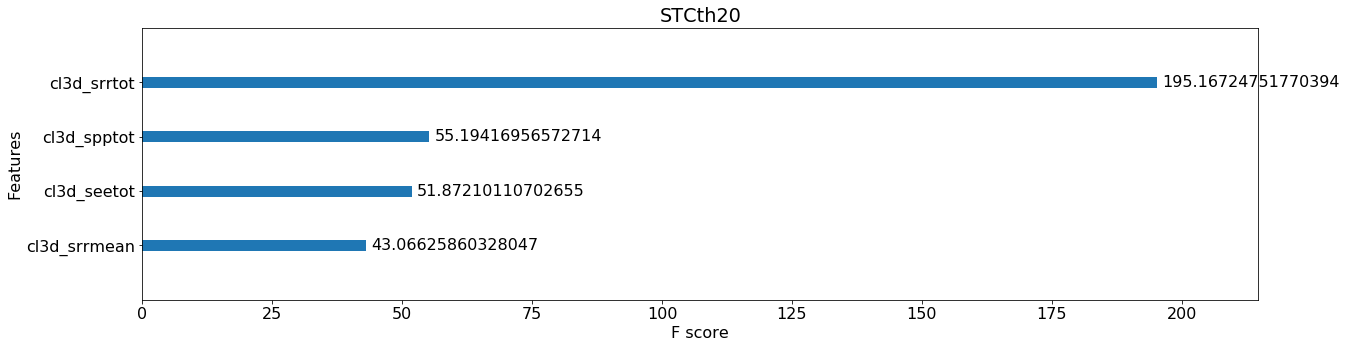

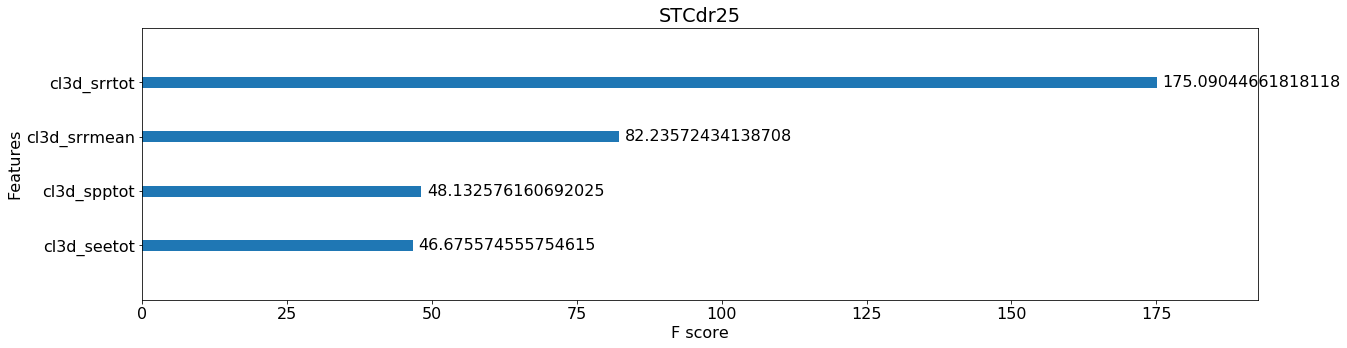

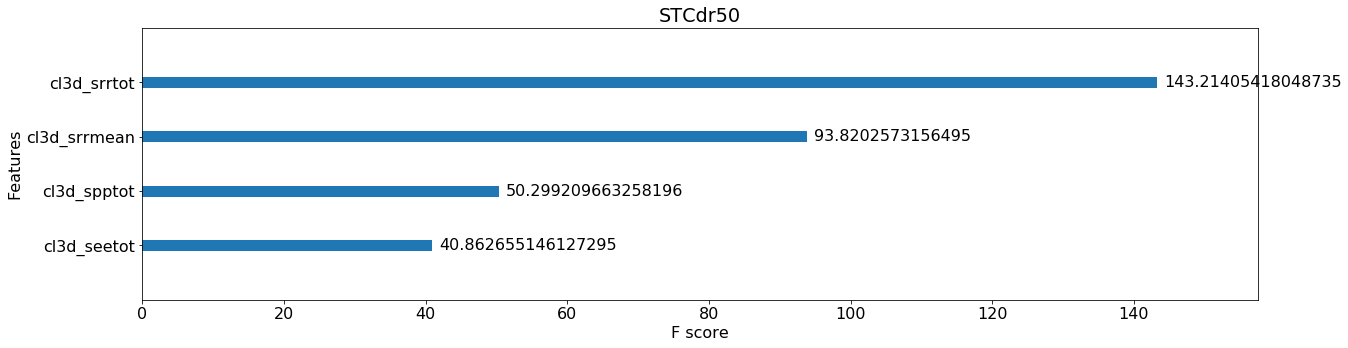

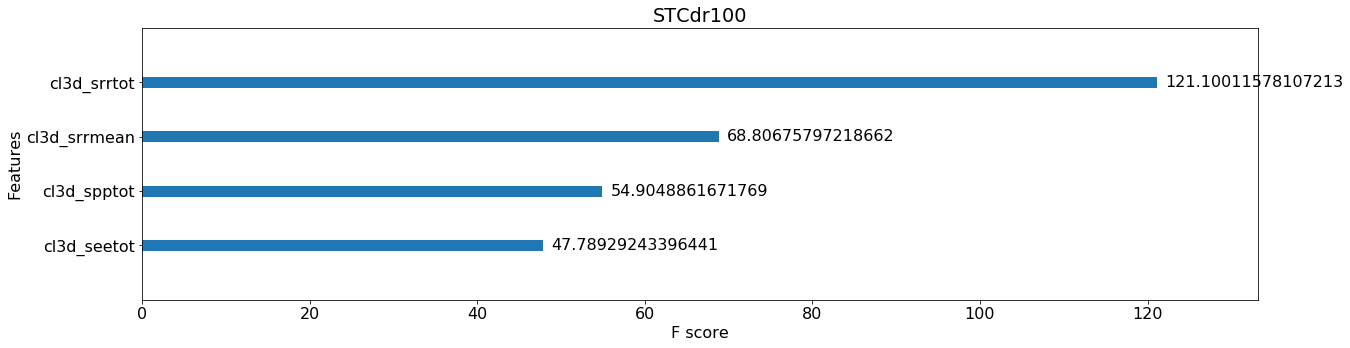

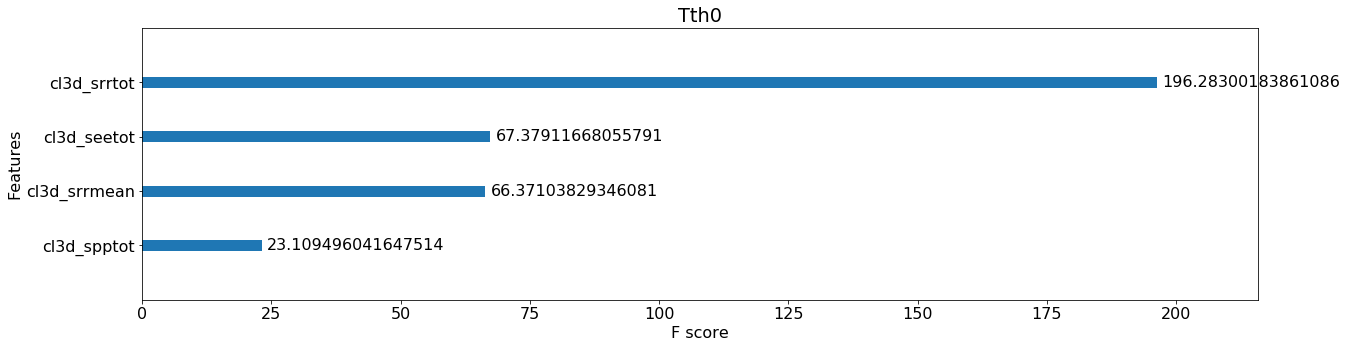

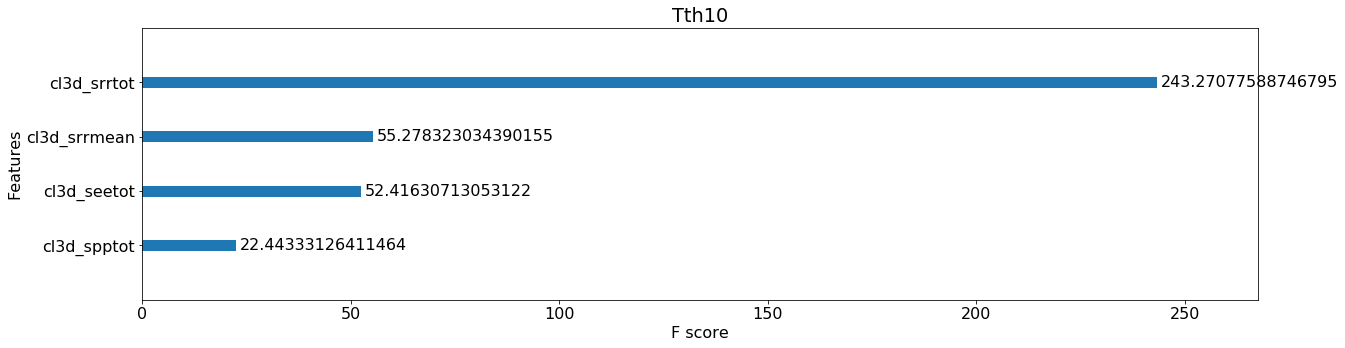

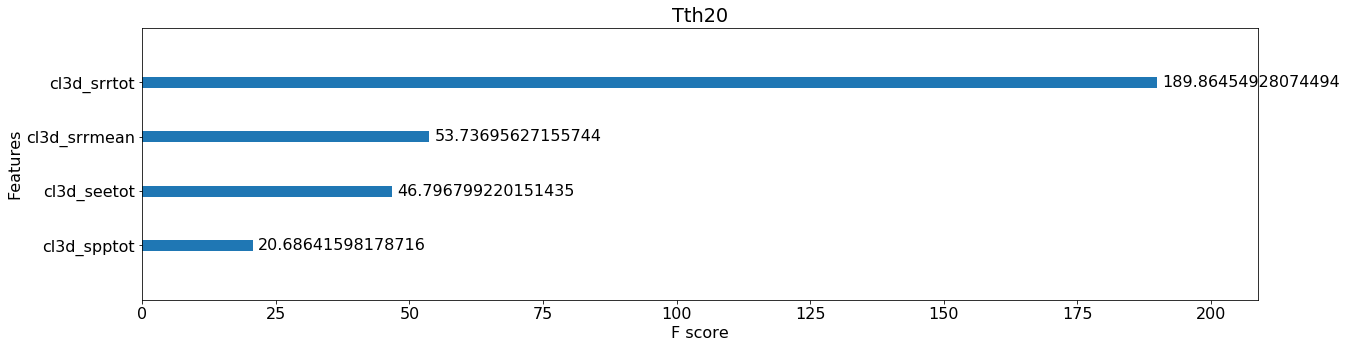

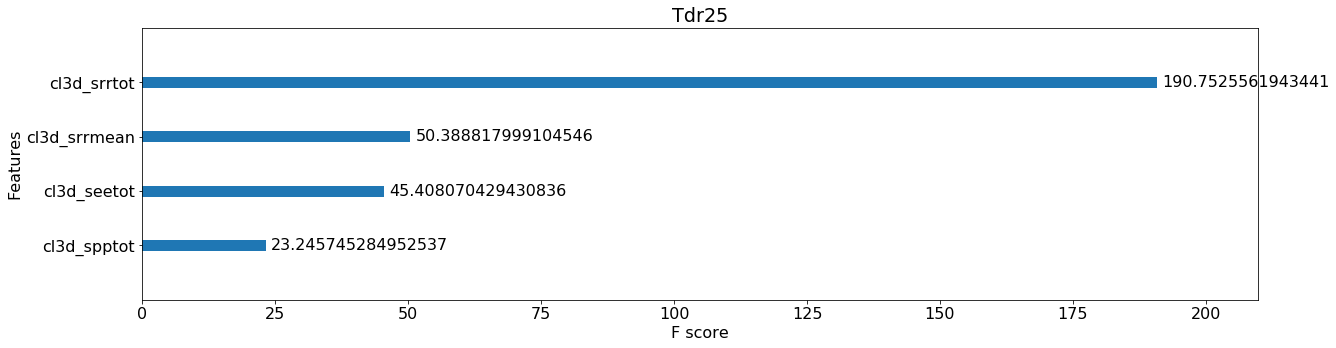

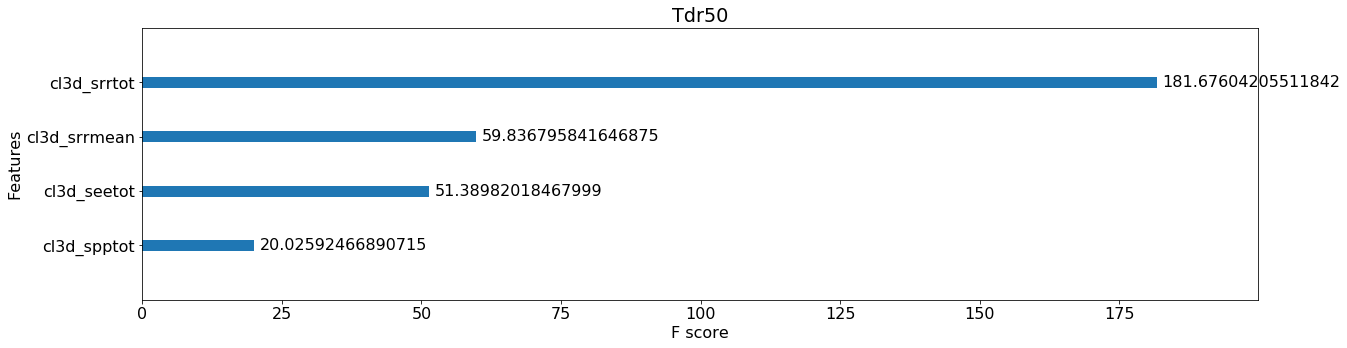

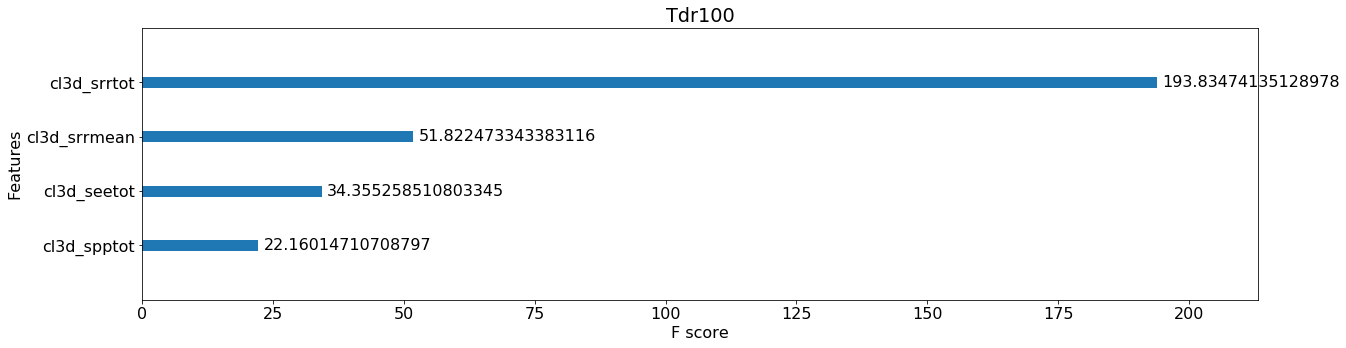

In [14]:
#plot importance of features for each algo
os.makedirs(fig_dir+'/importance', exist_ok=True)
matplotlib.rcParams.update({'font.size': 16})
for i in algo:
    plt.figure(figsize=(20,5))
    ax=plt.subplot(111)
    xgb.plot_importance(booster[i],ax,grid=False, title=algo_name[i], importance_type='gain');
    plt.savefig(fig_dir+'/importance/{}.png'.format(algo_name[i]))

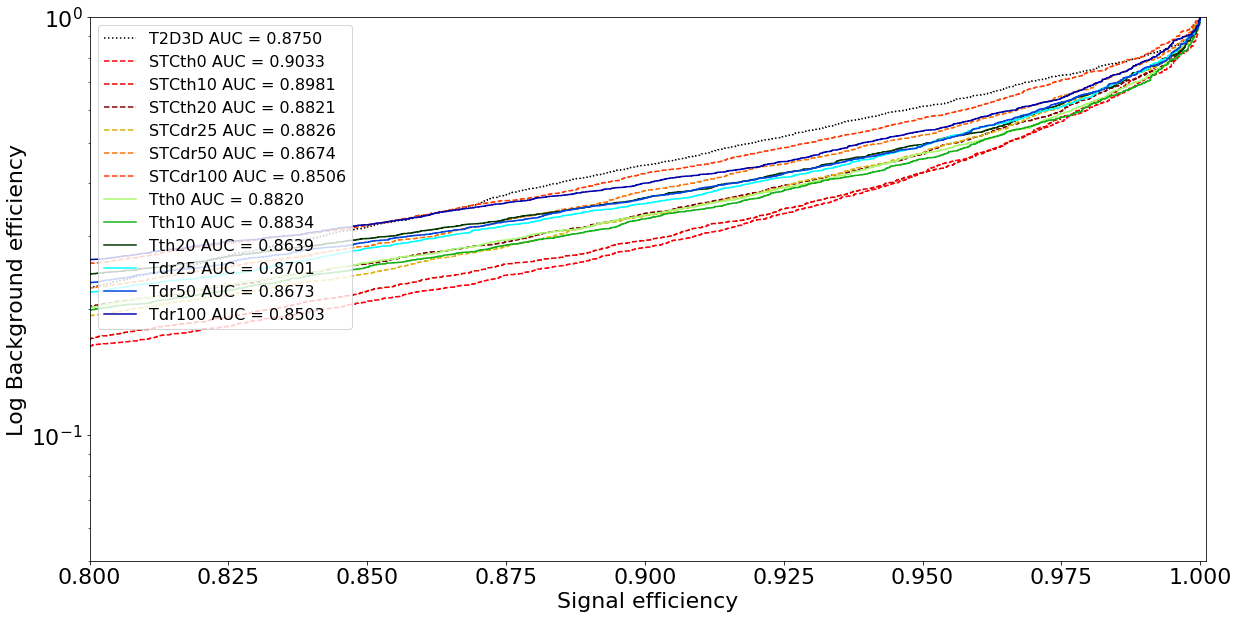

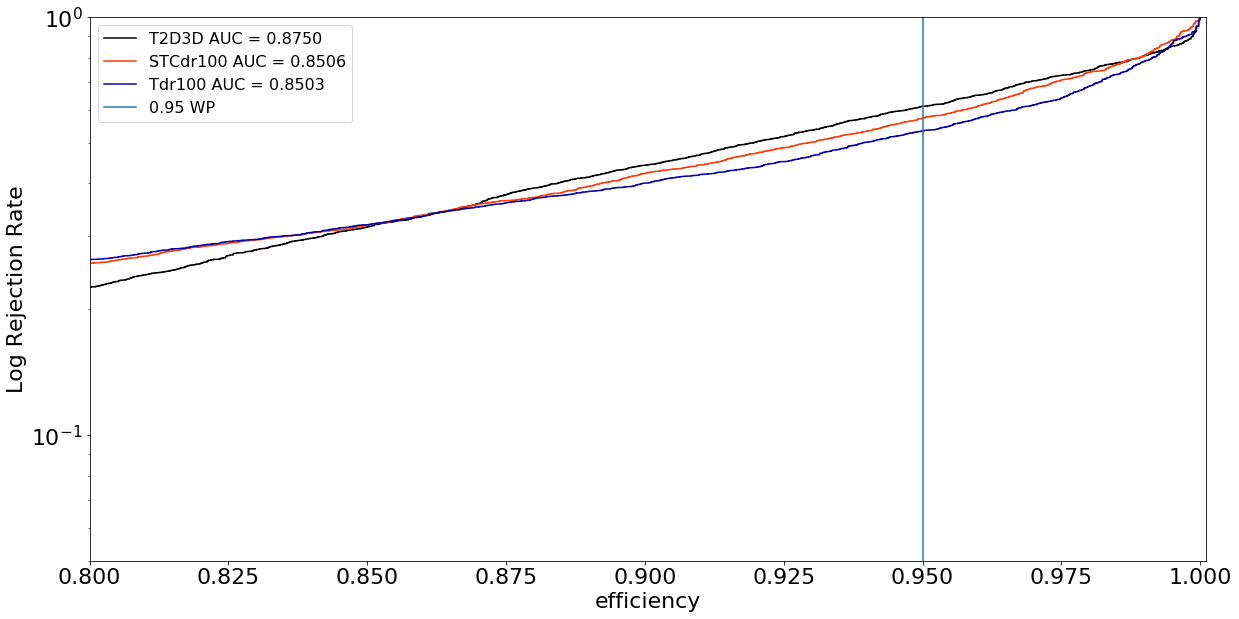

In [29]:
#build ROC
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for i in algo:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr, label ='%s AUC = %0.4f' %(algo_name[i],roc_auc), c=color[i], linestyle=style[i])
plt.legend(loc = 'upper left', fontsize=16)
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.8,1.001)
plt.yscale('log')
plt.ylim(0.05,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Log Background efficiency') 
plt.savefig(fig_dir+'/ROC.png')

plt.figure(figsize=(20,10))
for i in [0,6,12]:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr, label ='%s AUC = %0.4f' %(algo_name[i],roc_auc), c=color[i], linestyle='-')
plt.axvline(x=0.950, label='0.95 WP')
plt.legend(loc = 'upper left', fontsize=16)
plt.xlim(0.8,1.001)
plt.yscale('log')
plt.ylim(0.05,1)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate') 
plt.savefig(fig_dir+'/ROC_example.png')

In [16]:
def score(ytest, ypred, thr):
    fpr, tpr, threshold = metrics.roc_curve(ytest,ypred)
    roc=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    roc_cut=roc[roc['tpr']>thr];
    score=np.min(roc_cut['fpr']);
    return score

1 8


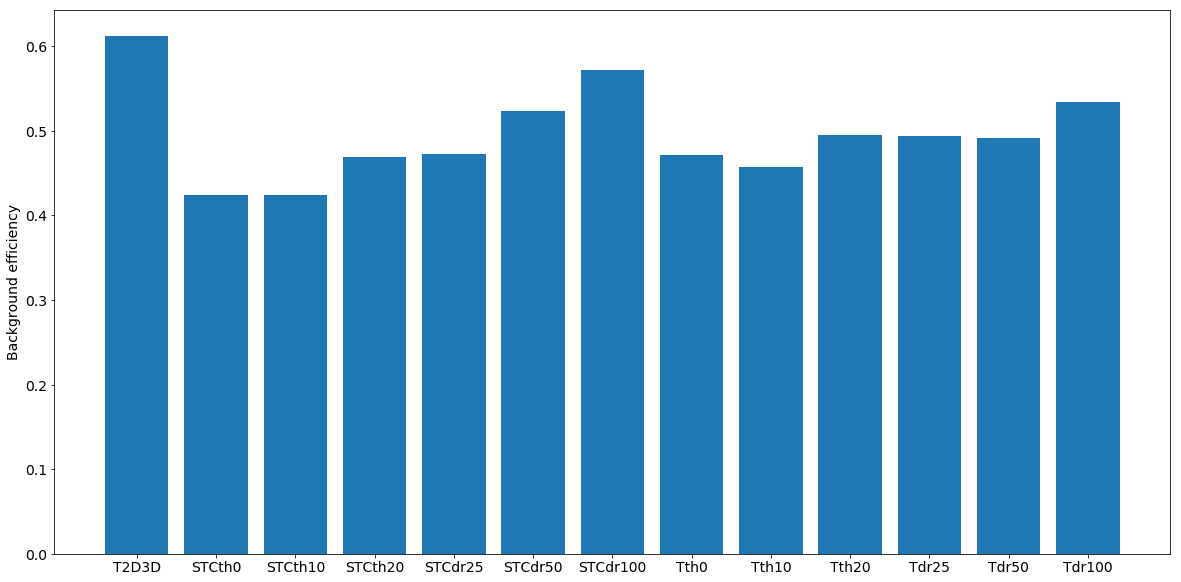

In [17]:
thr=0.95
scor=[]
best_STC_score=1
best_T_score=1

for i in algo:
    current_score=score(y_test[i], predictions[i],thr)
    scor.append(current_score)
    #print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])
    if i in [1,2,3,4,5,6]:
        if current_score < best_STC_score:
            best_STC_score=current_score
            best_STC=i
    if i in [7,8,9,10,11,12]:
        if current_score < best_T_score:
            best_T_score=current_score
            best_T=i

matplotlib.rcParams.update({'font.size': 14})
#plot background efficiency
plt.figure(figsize=(20,10))
plt.bar(np.arange(len(algo_name)), scor)
plt.xticks(np.arange(len(algo_name)), algo_name);
plt.ylabel('Background efficiency')
plt.savefig(fig_dir+'/efficiency.png')
print(best_STC, best_T)

In [18]:
#CALCULATE ERROR BARS

from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi

old bdt score: 0.33403127937783095


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Log Rejection Rate')

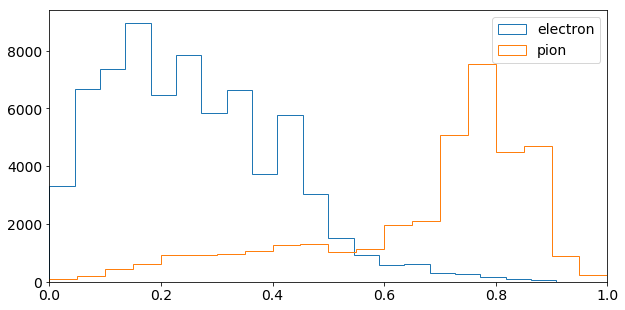

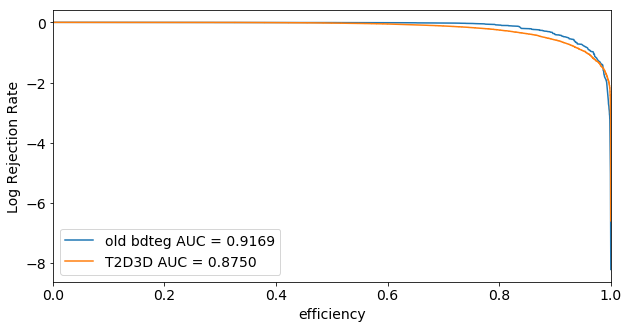

In [19]:
#comparison with old 2d3d algo
thr=0.9
#make the comparison
b=algo_cut[0].dropna()
a=b['cl3d_bdteg']
c=np.interp(a, (a.min(), a.max()), (1, 0))

score_old=score(b['genpart_pid'],c,thr)
print('old bdt score:', score_old)

i=0
nbins=20
plt.figure(figsize=(10,5))
plt.hist(c[b['genpart_pid']==0],histtype='step', bins=nbins, label='electron');
plt.hist(c[b['genpart_pid']==1],histtype='step',  bins=nbins, label='pion');
plt.legend()
plt.xlim(0,1)
i=0

plt.figure(figsize=(10,5))
fpr, tpr, threshold = metrics.roc_curve(b['genpart_pid'],c)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='old bdteg AUC = %0.4f' %(roc_auc))

fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
    
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0,1)
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate')  
#plt.savefig(fig_dir+'/old_roc.png')

In [20]:
def binning_pt(algo, thr, n_bins, a):
    pt_max=np.max(X_pt[i])
    pt_min=np.min(X_pt[i])
    range_pt= pt_max-pt_min
    if a != 1:
        x = (a-1)/((a**n_bins)-1)
    else: x = 1/n_bins
    bins_pt=[]
    score_pt=[]
    y_err_pt=[]
    y_err_pt_lo=[]
    y_err_pt_hi=[]
    pred_pt={}
    y_test_pt={}
    bin_end = pt_min
    
    
    for k in range(n_bins):
        bin_start = bin_end
        bin_end = bin_start + (a**k)*range_pt*x
        bins_pt.append((bin_start+bin_end)/2)
        sel=(X_pt[i] >= (bin_start)) & (X_pt[i] < (bin_end))
        pred_pt[k]=predictions[i][sel]    
        y_test_pt[k]=y_test[i][sel]
        score_pt.append(score(y_test_pt[k], pred_pt[k],thr))
        lo,hi=error(y_test_pt[k].shape[0], score(y_test_pt[k], pred_pt[k], thr), conf_level)
        y_err_pt_lo.append(lo)
        y_err_pt_hi.append(hi)
        y_err_pt=[y_err_pt_lo, y_err_pt_hi]
    return bins_pt, score_pt, y_err_pt


In [21]:
def binning_eta(algo, thr, n_bins, a):
    X_test[i]['abseta']=np.abs(X_test[i]['cl3d_eta'])
    eta_max=2.9
    eta_min=1.6
    range_eta= eta_max-eta_min
    if a != 1:
        x = (a-1)/((a**n_bins)-1)
    else: x = 1/n_bins
    bins_eta=[]
    score_eta=[]
    y_err_eta=[]
    y_err_eta_lo=[]
    y_err_eta_hi=[]
    pred_eta={}
    y_test_eta={}
    bin_end = eta_min
    
    
    for k in range(n_bins):
        bin_start = bin_end
        bin_end = bin_start + (a**k)*range_eta*x
        bins_eta.append((bin_start+bin_end)/2)
        sel=(X_test[i]['abseta'] > (bin_start)) & (X_test[i]['abseta'] < (bin_end))
        pred_eta[k]=predictions[i][sel]    
        y_test_eta[k]=y_test[i][sel]
        #print(pred_pt[k].shape[0])
        score_eta.append(score(y_test_eta[k], pred_eta[k],thr))
        #print('rejection rate for pt bin %d at %0.3f threshold=' %(j+1,thr),  score_pt[j])
        lo,hi=error(y_test_eta[k].shape[0], score(y_test_eta[k], pred_eta[k], thr), conf_level)
        y_err_eta_lo.append(lo)
        y_err_eta_hi.append(hi)
        y_err_eta=[y_err_eta_lo, y_err_eta_hi]
    return bins_eta, score_eta, y_err_eta

CPU times: user 9.32 s, sys: 6.48 s, total: 15.8 s
Wall time: 6.22 s


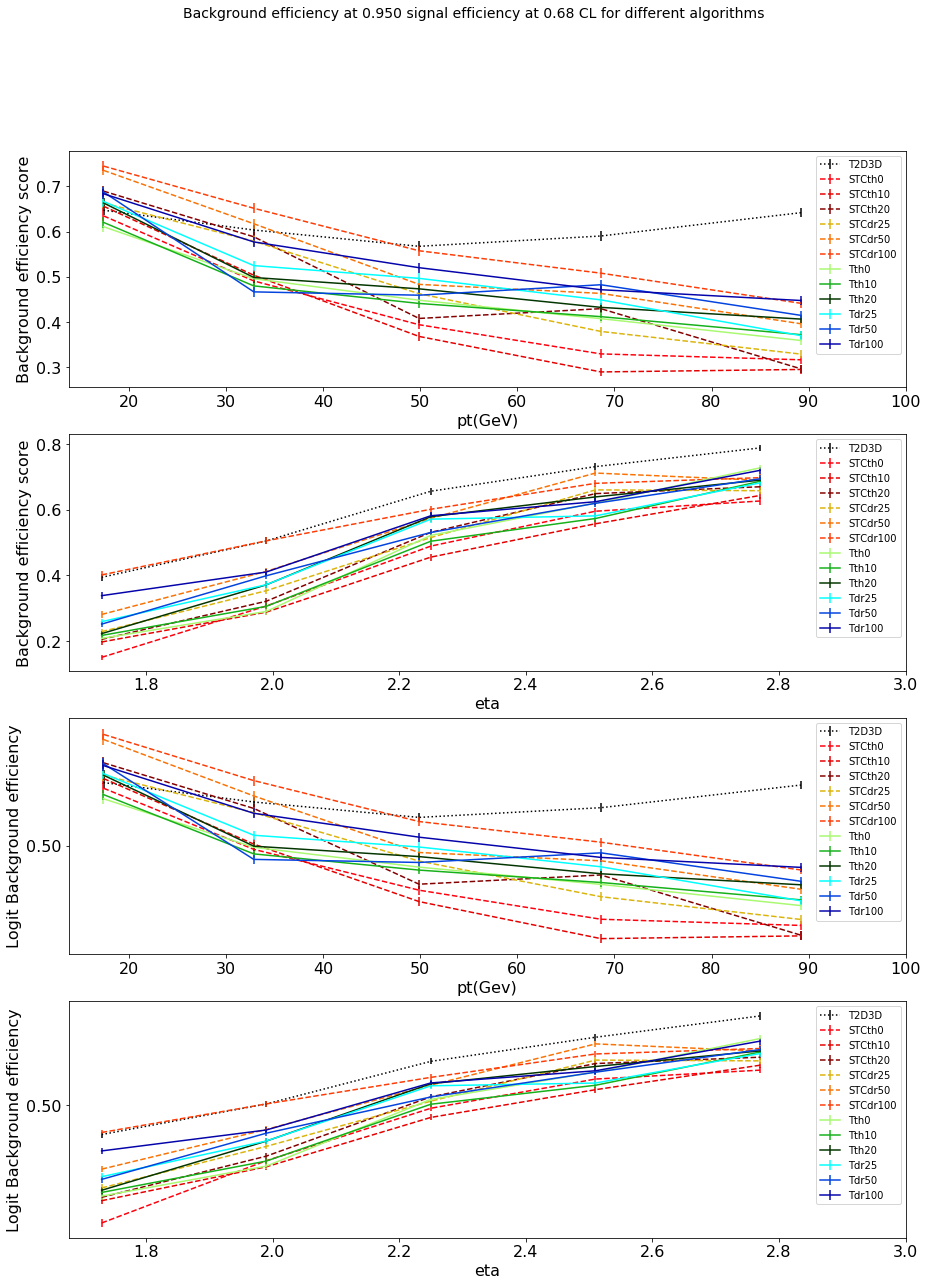

In [27]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.95
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137

matplotlib.rcParams.update({'font.size': 16})

color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt(GeV)');
   
    plt.xlim(right=100)
    plt.legend(fontsize=10)
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
 
    plt.legend(fontsize=10)
    plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency');
    plt.xlabel('pt(Gev)');
    plt.xlim(right=100)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    
    plt.legend(fontsize=10)
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
   
    plt.xlim(right=3.0)
    plt.legend(fontsize=10)
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP.png'.format(thr))

CPU times: user 9.35 s, sys: 6.47 s, total: 15.8 s
Wall time: 6.21 s


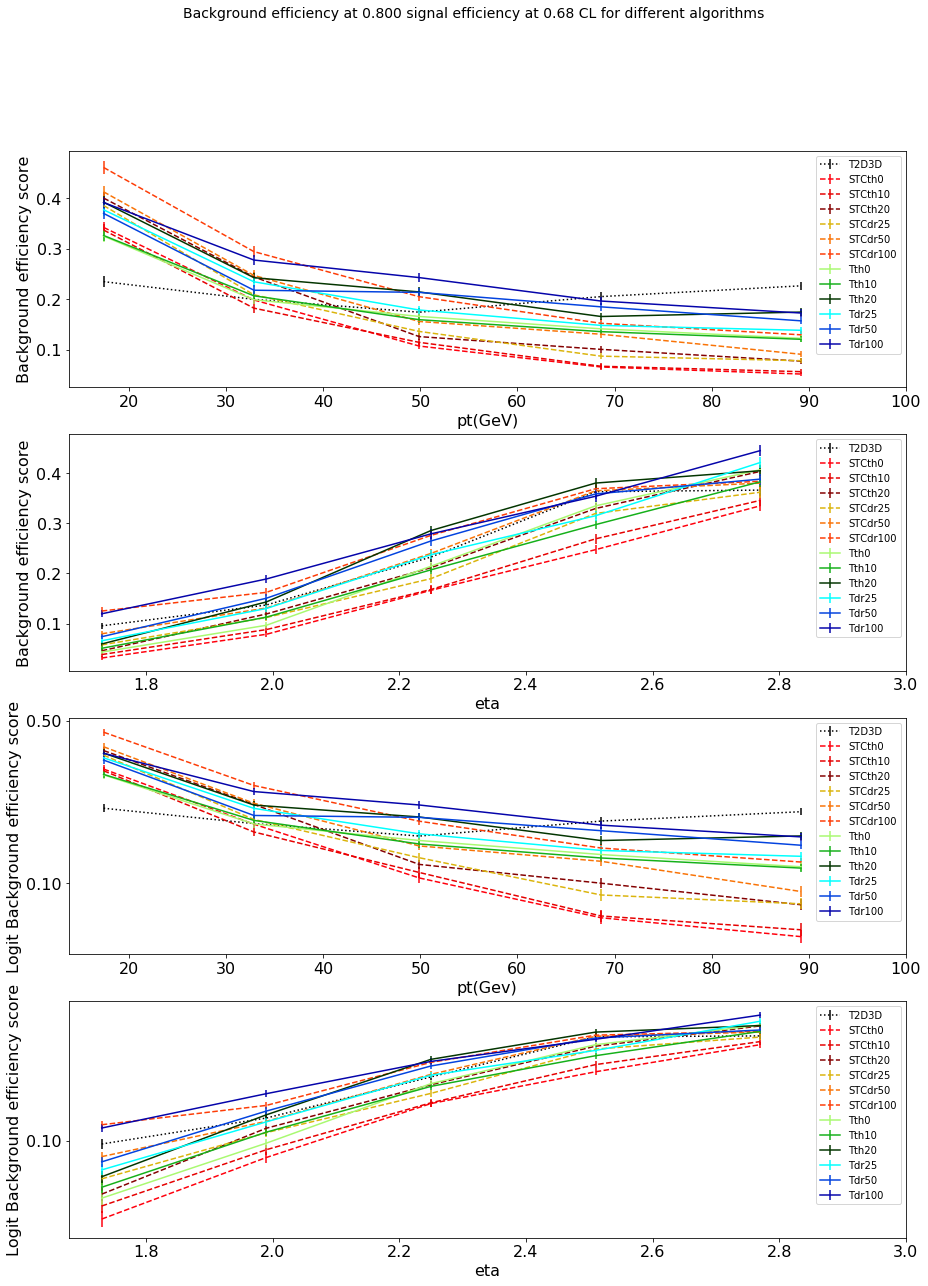

In [23]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.8
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137

matplotlib.rcParams.update({'font.size': 16})
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt(GeV)');
    #plt.ylim(-0.01,0.2)
    plt.xlim(right=100)
    plt.legend(fontsize=10)
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
    #plt.ylim(0,0.1)
    plt.legend(fontsize=10)
    plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('pt(Gev)');
    plt.xlim(right=100)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.00001,0.4)
    plt.legend(fontsize=10)
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    #plt.ylim(0.001,0.2)
    plt.xlim(right=3.0)
    plt.legend(fontsize=10)
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP.png'.format(thr))

CPU times: user 4.78 s, sys: 3.72 s, total: 8.5 s
Wall time: 2.95 s


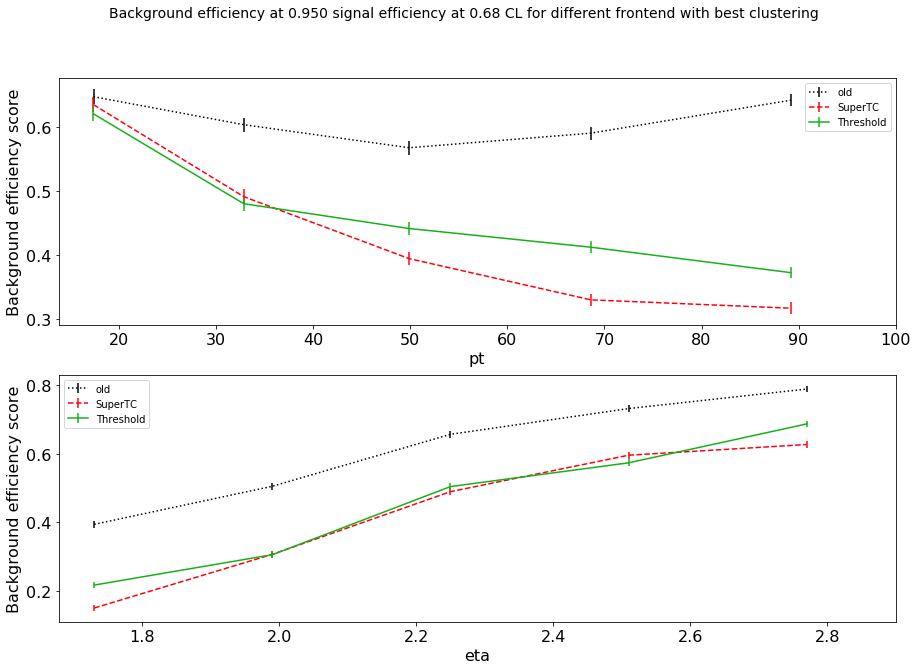

In [30]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,10))
thr=0.95
nbins=5
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
score_pt_best=[]
score_eta_best=[]
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']
frontend=['old','SuperTC','SuperTC','SuperTC','SuperTC','SuperTC','SuperTC','Threshold','Threshold','Threshold','Threshold','Threshold','Threshold']
matplotlib.rcParams.update({'font.size': 16})

for i in algo:
    current_score=score(y_test[i], predictions[i],thr)
    scor.append(current_score)
    #print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])
    if i in [1,2,3,4,5,6]:
        if current_score < best_STC_score:
            best_STC_score=current_score
            best_STC=i
    if i in [7,8,9,10,11,12]:
        if current_score < best_T_score:
            best_T_score=current_score
            best_T=i

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
        
    if i in [0,best_STC, best_T]:
       
        plt.subplot(211);
        plt.errorbar(bins_pt, score_pt, y_err_pt, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('pt');
        plt.xlim(right=100)
        
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
       
        plt.legend(fontsize=10)

        plt.subplot(212);
        plt.errorbar(bins_eta, score_eta, y_err_eta, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('eta');
        
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        
        plt.xlim(right=2.9)
        plt.legend(fontsize=10)

   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different frontend with best clustering' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_best.png'.format(thr))

CPU times: user 4.77 s, sys: 3.77 s, total: 8.53 s
Wall time: 2.96 s


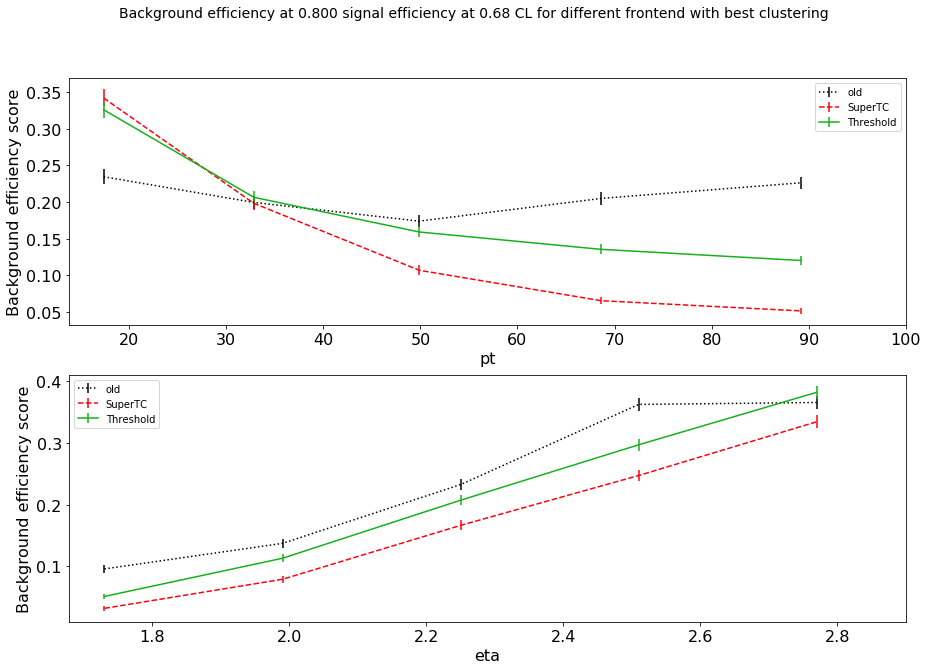

In [25]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,10))
thr=0.8
nbins=5
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
score_pt_best=[]
score_eta_best=[]
color=['black', 'xkcd:bright red', 'xkcd:red', 'xkcd:dark red', 'xkcd:gold', 'xkcd:orange', 'xkcd:red orange',
       'xkcd:spring green', 'xkcd:green', 'xkcd:dark green', 'xkcd:cyan', 'xkcd:blue', 'xkcd:royal blue']
style=[':' ,'--','--','--','--','--','--','-','-','-','-','-','-']
frontend=['old','SuperTC','SuperTC','SuperTC','SuperTC','SuperTC','SuperTC','Threshold','Threshold','Threshold','Threshold','Threshold','Threshold']
matplotlib.rcParams.update({'font.size': 16})

for i in algo:
    current_score=score(y_test[i], predictions[i],thr)
    scor.append(current_score)
    #print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])
    if i in [1,2,3,4,5,6]:
        if current_score < best_STC_score:
            best_STC_score=current_score
            best_STC=i
    if i in [7,8,9,10,11,12]:
        if current_score < best_T_score:
            best_T_score=current_score
            best_T=i

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
        
    if i in [0,best_STC, best_T]:
       
        plt.subplot(211);
        plt.errorbar(bins_pt, score_pt, y_err_pt, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('pt');
        plt.xlim(right=100)
        
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        
        plt.legend(fontsize=10)

        plt.subplot(212);
        plt.errorbar(bins_eta, score_eta, y_err_eta, label=frontend[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('eta');
        
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        
        plt.xlim(right=2.9)
        plt.legend(fontsize=10)

   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different frontend with best clustering' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_best.png'.format(thr))

CPU times: user 9.33 s, sys: 6 s, total: 15.3 s
Wall time: 6.51 s


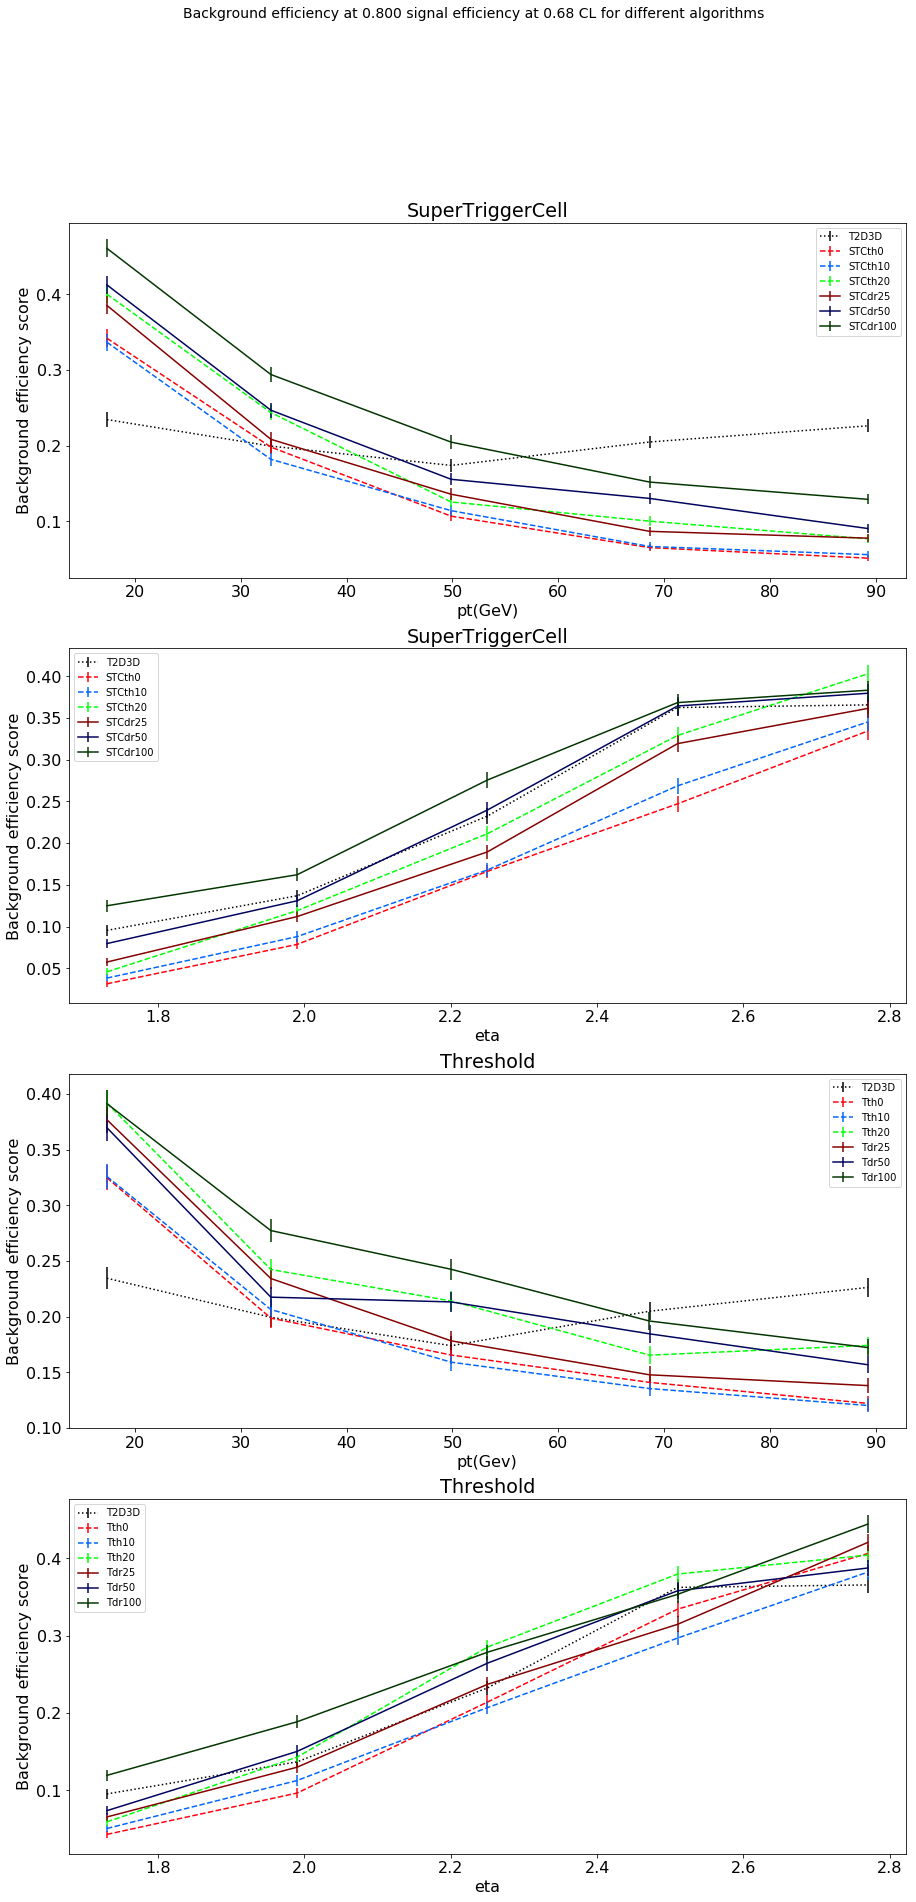

In [26]:
%%time
#plot score
os.makedirs(fig_dir+'/score', exist_ok=True)
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,30))
thr=0.8
nbins=5
a = 1.1 #increasing factor
conf_level=0.682689492137


color=['black', 'xkcd:bright red', 'xkcd:bright blue', 'xkcd:bright green', 'xkcd:dark red', 'xkcd:dark blue', 'xkcd:dark green',
       'xkcd:bright red', 'xkcd:bright blue', 'xkcd:bright green', 'xkcd:dark red', 'xkcd:dark blue', 'xkcd:dark green']
style=[':' ,'--','--','--','-','-','-','--','--','--','-','-','-']
matplotlib.rcParams.update({'font.size': 16})

for i in algo:
    
    bins_pt, score_pt, y_err_pt=binning_pt(i, thr, nbins, a)
    bins_eta, score_eta, y_err_eta=binning_eta(i, thr, nbins, 1)
    
    if i <= 6: 
        plt.subplot(411);
        plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('pt(GeV)');
        #plt.ylim(-0.01,0.2)
        #plt.xlim(right=100)
        plt.legend(fontsize=10)
        plt.title('SuperTriggerCell')

        plt.subplot(412);
        plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('eta');
        #plt.ylim(0,0.1)
        plt.legend(fontsize=10)
        #plt.xlim(right=3.0)
        plt.title('SuperTriggerCell')
        
    if i ==0 or i >=7:
        plt.subplot(413);
        plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('pt(Gev)');
        #plt.xlim(right=100)
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.00001,0.4)
        plt.legend(fontsize=10)
        plt.title('Threshold')

        plt.subplot(414);
        plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i],c=color[i], fmt=style[i]);
        plt.ylabel('Background efficiency score');
        plt.xlabel('eta');
        #plt.yscale('logit')
        plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
        #plt.ylim(0.001,0.2)
        #plt.xlim(right=3.0)
        plt.legend(fontsize=10)
        plt.title('Threshold')
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/score/Algo_comparison_{}WP_FE.png'.format(thr))